# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os

from pyspark.sql import SparkSession;
from pyspark.sql.functions import regexp_replace, avg, isnan, countDistinct, count,when,col, concat, desc, explode, lit, min, max, split, udf, isnull;
from pyspark.sql.types import IntegerType;

from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;

from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

import re;
import datetime;

import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
import numpy as np;
from itertools import cycle, islice;

In [2]:
# create a Spark session
spark = SparkSession\
                    .builder\
                    .master('local')\
                    .appName("Sparkify Project")\
                    .getOrCreate();

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load data "mini_sparkify_event_data.json"
df = spark.read.json('mini_sparkify_event_data.json');

#see top records in dataset
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
print(df.take(5));

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Ba

In [6]:
#lets look at shema of data :
df.printSchema();

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# number of rows in the dataframe
df.count()

286500

In [8]:
# number of columns in the dataframe
len(df.columns)

18

In [9]:
print("Number of  Rows in the dataframe:{}".format(df.count()));
print("Number of  columns in the dataframe:{}".format(len(df.columns)));
print("columns Present in data set in the dataframe{}".format(df.columns));

Number of  Rows in the dataframe:286500
Number of  columns in the dataframe:18
columns Present in data set in the dataframe['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [10]:
#discribing all the columns in dataframe
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


After cleaning the dataset, we now checking for invalid or missing data. To illustrate, records without userids or session id's

In [11]:
# check null values in columns(userId and sessionId has none)
df.toPandas().isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [12]:
# sum all null items
df.toPandas().isnull().sum().sum()

225252

In [13]:
# inspect userId column for the first 20 columns
df.select('userId').dropDuplicates().sort('userId').show(20)


+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [14]:
# drop empty strings for userId
df = df.filter(df['userId'] != '')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn is an event that occurs when a user discontinues a subscription from a business.

## Preliminary Exploratory Data analysis

##### Using page =='Cancellation Confirmation' & auth =='Cancelled' we can deduce our Target Variable ie. if users churn or not

In [15]:
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      10082|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        495|
|            Settings|       1514|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1454|
|             Upgrade|        499|
|               Error|        252|
|      Submit Upgrade|        159|
+--------------------+-----------+



In [16]:
df.select('auth','UserId').groupby('auth').agg({'auth':'count'}).select('auth','count(auth)').show()

+---------+-----------+
|     auth|count(auth)|
+---------+-----------+
|Cancelled|         52|
|Logged In|     278102|
+---------+-----------+



## Observations:

This dataframe groupings above shows the same value counts for cancelled and cancellation confirmation attribute. This is a confirmation that there is no userId with only one factor. Users with cancellation confirmation requests also executed the cancelled feature.

These are good indicators to easily identify churned users. In summary, we could define churned users as those users who have visited the ‘Cancelation Confirmation’ page and also definitely visited 'Cancelled' page. In addition, we could take the ‘Submit Downgrade’ column into consideration.

### Label to caterorize targets(churn or not)



Next, let us define a churn column by using a user defined function which labels all churned users with a 1 and 0 if otherwise:

In [17]:
def label(df):
    """
    Function to create a dataframe containing targets column(0-churn and 1-non-churn) and respective counts
    Input 
    df: spark DataFrame
    Output 
    df : contains labelled targets with the churn column
    """
   
    label_df=df.withColumn('churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0)).\
                            groupBy('userId').agg(Fsum('churn').alias('churn'))
    print(label_df.groupBy('churn').count().show())
    churned_rate = label_df.select(avg("churn")).collect()[0]["avg(churn)"]
    print(f"percentage churn: {churned_rate * 100:,.2f}%")

    df = df.join(label_df, on='userId')
    return df

In [18]:
df = label(df)

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+

None
percentage churn: 23.11%


## Analyzing users that stayed versus users that churned using certain features

In [19]:
#Exploratory Data Analysis using various columns
def exploratory_data_analysis(df,col_name):
    """
    prints countplot of input col
    Input 
    df: spark DataFrame
    col_name : the column with counted values
    Output :
    None
    
    """
    pd = df.select(["userId", col_name, "churn"]).toPandas()
    sns.countplot(x=col_name, hue="churn", data=pd);

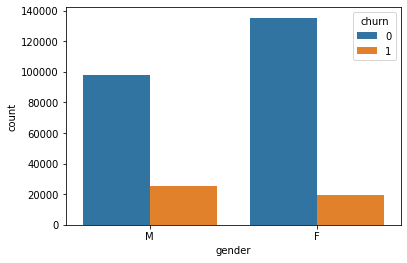

In [20]:
# exploratory data analysis per gender
exploratory_data_analysis(df,"gender")

##### From the visulaization above more male users churn than female users

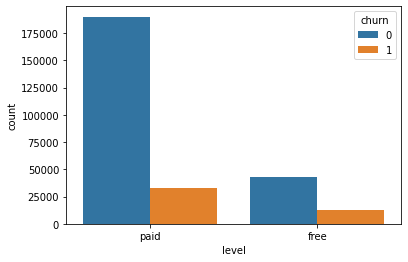

In [21]:
# exploratory data analysis per level
exploratory_data_analysis(df,"level")

##### From the visualization above users that paid for the services have higher churn rate than users that access services for free

In [22]:
# location name too long;  extract states from its respective location
df = df.withColumn("location", regexp_replace("location", '[^a-zA-Z0-9\,\-]', ''))\
        .withColumn('location', split(col('location'),',').getItem(1))
df.select('location').show(n=10)

+--------+
|location|
+--------+
|      CA|
|   MA-NH|
|      CA|
|   MA-NH|
|      CA|
|   MA-NH|
|   MA-NH|
|      CA|
|      CA|
|      CA|
+--------+
only showing top 10 rows



<AxesSubplot:xlabel='location'>

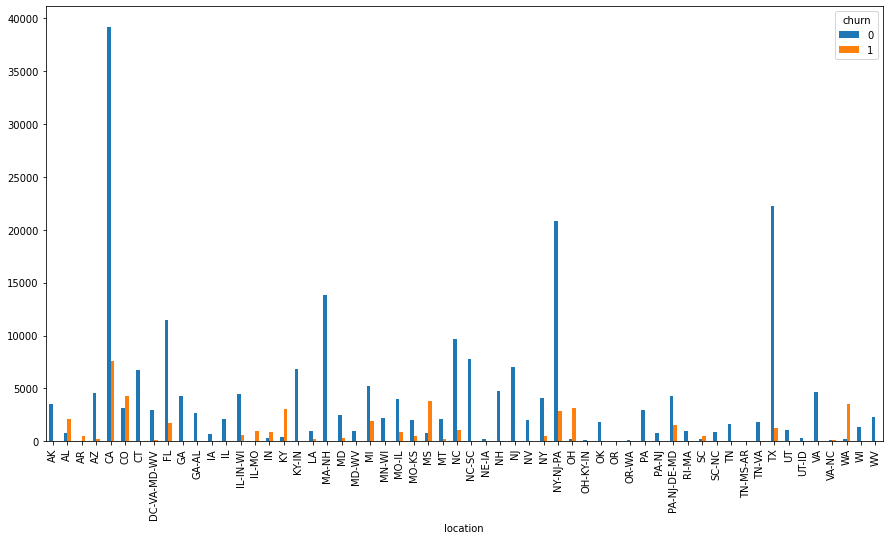

In [23]:
# exploratory data analysis per location
df_state_count= df.select('userId','location','churn').groupby('location','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count.pivot(index='location', columns='churn', values='count').plot(kind='bar', ax=ax)

##### From the visulization above, some locations have churned users while others have no churned users at all.

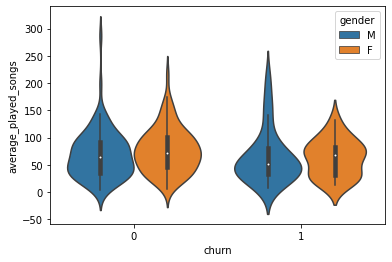

In [24]:
# Lets visualize the gender distribution for number of songs played per session for churned and active users
total_songs_df = df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'average_played_songs').toPandas()

ax = sns.violinplot('churn', y = 'average_played_songs', hue = 'gender', data = total_songs_df)



###### From the visualization above, we can clearly observe that the churned users played less number of songs per session when compared to active users 

<AxesSubplot:xlabel='count', ylabel='churn'>

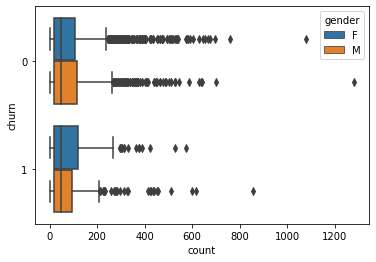

In [25]:
# Let's visualize the gender distribution for total number of operations per session between normal and churned users
df_ops = df.groupby("churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'churn', orient = 'horizontal', data = df_ops, hue = 'gender')

###### From the visualization above, we can clearly observe that churned users performed lesser number of operations compared to active users. Also male users display higher churn rate than female users.

###  "Submit Downgrade" is an indicator for Users Churn or not.¶

In [26]:
#EDA using downgrade events
df.filter((col('page')=='Downgrade')&(col('churn')==1)).select('userId').distinct().count()

35

##### Out of the 52 churned users 35 downgraded their service

In [27]:
df.filter((col('page')=='Submit Downgrade')&(col('churn')==1)).select('userId').distinct().count()

9

##### Now, observing the submit downgrade feature, only  9 users submitted downgrade out of 52 churned users. This is an indicator that active users submits service downgrade than churned users.

In [28]:
df.filter((col('page')=='Submit Downgrade')&(col('churn')==0)).select('userId').distinct().count()

40

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
# Feature one : Total number of songs each user listened to
feat_one = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'count_songs')
feat_one.show()

+------+-----------+
|userId|count_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



In [30]:
# Feature two : Total number of thumbs up from each user
feat_two = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'count_thumbs_up')
feat_two.show()

+------+---------------+
|userId|count_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
|   112|              9|
+------+---------------+
only showing top 20 rows



In [31]:
# Feature three : Total number of thumbs down from each user
feat_three = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'count_thumbs_down')
feat_three.show()

+------+-----------------+
|userId|count_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
|    15|               14|
|    54|               29|
|   155|                3|
|   132|               17|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
|   112|                3|
|    73|                7|
+------+-----------------+
only showing top 20 rows



In [32]:
# Feature four : Total time spent as a an active user since registration
feat_four = df.select('userId', 'registration', 'ts').withColumn('count_usagetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'count_usagetime' : 'max'})\
    .withColumnRenamed('max(count_usagetime)', 'count_usagetime')\
    .select('userId', (col('count_usagetime')/1000/3600/24).alias('count_usagetime'))
feat_four.show()

+------+------------------+
|userId|   count_usagetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [33]:
# Feature five : Total length of time spent listening utilizing all services
feat_five = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'count_listening_time')
feat_five.show()

+------+--------------------+
|userId|count_listening_time|
+------+--------------------+
|100010|   66940.89735000003|
|200002|   94008.87593999993|
|   125|  2089.1131000000005|
|    51|   523275.8428000004|
|   124|  1012312.0927899999|
|     7|   38034.08710000002|
|    54|   711344.9195400011|
|    15|  477307.60581000015|
|   155|         198779.2919|
|   132|   483118.9038399997|
|   154|  20660.023910000007|
|100014|   67703.47208000004|
|   101|   447464.0146699989|
|    11|  159669.96303999983|
|   138|   512449.8827599989|
|300017|   897406.9802100015|
|    29|   754517.5625700009|
|    69|   286064.0256399999|
|100021|   57633.17563999999|
|    42|   881792.9661300007|
+------+--------------------+
only showing top 20 rows



In [34]:
# Feature six : Total number of friends
feat_six = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'count_friends')
feat_six.show()

+------+-------------+
|userId|count_friends|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



In [ ]:
# Feature seven : Total number of songs listened per session
feat_seven  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'count_average_played_songs')

feat_seven.show()

In [ ]:
# Feature eight : Total number of artists each user has listened to
feat_eight = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "count_artist_listened_to")
feat_eight.show()

In [ ]:
# Feature nine : Total number of help requested from each user
feat_nine = df.select('userId', 'page').where(df.page == 'Help').groupBy('userId').count().withColumnRenamed('count', 'count_help')
feat_nine.show()

In [ ]:
# Feature ten : Gender of the user
feat_ten = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

feat_ten.show()

In [ ]:
# assign target lebels denoting churn or not for each user
target = df.select('userId', col('churn').alias('target')).dropDuplicates()
target.show()

In [ ]:
# Combine all features with the target churn label

overall_data = feat_one.join(feat_two, 'userId', 'inner').join(feat_three, 'userId', 'inner').join(feat_four, 'userId', 'inner')\
             .join(feat_five, 'userId', 'inner').join(feat_six, 'userId', 'inner').join(feat_seven, 'userId', 'inner')\
             .join(feat_eight, 'userId', 'inner').join(feat_nine, 'userId', 'inner').join(feat_ten, 'userId', 'inner').join(target, 'userId', 'inner').drop('userId')

overall_data.show()

In [ ]:
overall_df = overall_data.toPandas()

In [ ]:
# check for missing values
overall_df.isnull().sum()


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.